In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
import tweepy
from tweepy import OAuthHandler

consumer_key = 'BlttlisbFluOUuRIqARW3UXW6'
consumer_secret = 'fWrrwZNcNg7WOOLZft5szH9mQSuXXZc9toaoWK7A0t3roSiNmj'
access_token = '1916058374-p7NdDp6FPhSEAFxFwAYwzhOgbJVcQk5eMSZN7qw'
access_secret = 'qrsF1CfXsAsJwnWCtSkshuvQaVCRLYr6aHeHwrmpea5LJ'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, timeout=10, wait_on_rate_limit=True)

In [3]:
def fetch_tweets(n, query=''):
    try:
        list_tweets = []
        for status in tweepy.Cursor(api.search, q=query+" -filter:retweets", lang='en', result_type='recent').items(n):
            list_tweets.append(status.text)
        return list_tweets
    except Exception as e:
        print(e)

In [4]:
query = "MSDhoni"
data = fetch_tweets(180, query)

In [5]:
def tokenize_tweets(hashtag):
    REGEX = re.compile(r"[A-Z][a-z]+|[0-9]+[a-z]*|[A-Z]+?|[a-z]+")
    if len(hashtag.split()) == 1:
        return REGEX.findall(hashtag)
    return hashtag.split()

In [6]:
def remove_url(text):
    URL_REGEX = re.compile(r'''((http[s]?://)[^ <>'"{}|\^`[\]]*)''')
    return URL_REGEX.sub(r' ', text)

data = list(map(remove_url, data))
data = list(map(lambda x: x.replace('#', ''), data))

In [7]:
def get_entities(sent):
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""
    prv_tok_text = ""

    prefix = ""
    modifier = ""
    
    for tok in nlp(sent):
        if tok.dep_ != "punct":
            if tok.dep_ == "compound":
                prefix = tok.text
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text
      
      
        if tok.dep_.endswith("mod") == True:
            modifier = tok.text
            if prv_tok_dep == "compound":
                modifier = prv_tok_text + " "+ tok.text
      
        if tok.dep_.find("subj") == True:
            ent1 = modifier +" "+ prefix + " "+ tok.text
            prefix = ""
            modifier = ""
            prv_tok_dep = ""
            prv_tok_text = ""      

        if tok.dep_.find("obj") == True:
            ent2 = modifier +" "+ prefix +" "+ tok.text
        
        prv_tok_dep = tok.dep_
        prv_tok_text = tok.text

    return [ent1.strip(), ent2.strip()]

In [8]:
entity_pairs = []

for i in tqdm(data):
    entity_pairs.append(get_entities(i))

In [9]:
def get_relation(sent):
    doc = nlp(sent)
    matcher = Matcher(nlp.vocab)
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 
    matcher.add("matching_1", None, pattern) 
    matches = matcher(doc)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]] 
    return(span.text)

In [10]:
relations = [get_relation(i) for i in tqdm(data)]

In [11]:
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

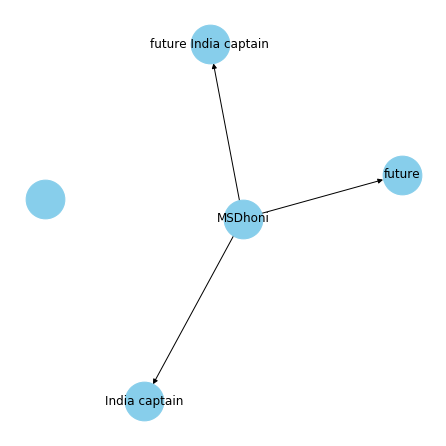

In [12]:
query_ = ' '.join(tokenize_tweets(query))
G=nx.from_pandas_edgelist(kg_df[(kg_df['source']==query) | (kg_df['target']==query) | (kg_df['edge']==query) |
                                (kg_df['source']==query_) | (kg_df['target']==query_)| (kg_df['edge']==query_)],
                          "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(6,6))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()